# Scikit-learn tutorial for processing and classifying text data

## Load and process text data

In [39]:
# Categories of documents
categories = ['alt.atheism', 'talk.religion.misc',
              'comp.graphics', 'sci.med']

In [54]:
# Load newsgroup data
from sklearn.datasets import fetch_20newsgroups

twenty_train = fetch_20newsgroups(subset='train',
    categories=categories, shuffle=True, random_state=42)
    
# remove=("headers", "footers"))

In [55]:
# Print categories
twenty_train.target_names

['alt.atheism', 'comp.graphics', 'sci.med', 'talk.religion.misc']

In [56]:
# Check data and filenames size
print(len(twenty_train.data))
print(len(twenty_train.filenames))

2035
2035


In [57]:
# Print example document

doc_i = 1

print("\n".join(twenty_train.data[doc_i].split("\n")[:10]))

# Print target for example document
print(twenty_train.target_names[twenty_train.target[doc_i]])

From: lansd@dgp.toronto.edu (Robert Lansdale)
Subject: Advice sought: Turning font outlines into renderable polygons
Organization: CSRI, University of Toronto
Distribution: na
Lines: 53


I am seeking some alternate solutions on how to turn a Postscript Type 1 or
TrueType font outline into polygons that can be subsequently scan converted
by a 3D scanline renderer. 
comp.graphics


In [15]:
# Check the target indices for the first 10 datapoints
twenty_train.target[:10]

array([0, 1, 2, 2, 1, 3, 3, 1, 1, 0], dtype=int64)

In [53]:
# Print the actual target names of the first 10 observations
for t in twenty_train.target[:10]:
    print(twenty_train.target_names[t])

alt.atheism
comp.graphics
sci.med
sci.med
comp.graphics
talk.religion.misc
talk.religion.misc
comp.graphics
comp.graphics
alt.atheism


In [78]:
# Convert text to numerical data
from sklearn.feature_extraction.text import CountVectorizer

# Calculate occurrences of words in documents
count_vect = CountVectorizer()

# Transform data from text to word occurrences
X_train_counts = count_vect.fit_transform(twenty_train.data)

# Check shape of transformed dataset
print(X_train_counts.shape)

# Preview bag of words
X_train_counts.toarray()

(2035, 34624)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [77]:
# Count number of words for each document
X_train_counts.toarray().sum(axis=1)

array([267, 428, 190, ..., 193,  76, 134], dtype=int64)

In [93]:
# Convert occurrences into tf-idf features (normalized occurences)
from sklearn.feature_extraction.text import TfidfTransformer

# Transform previous features to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# Check shape of the dataset
print(X_train_tfidf.shape)

(2035, 34624)


## Classify text data

In [19]:
# Load machine learning classifier
from sklearn.naive_bayes import MultinomialNB

# Train classifier
clf = MultinomialNB().fit(X_train_tfidf, twenty_train.target)

In [21]:
# Classify new document

# Create two new documents
docs_new = ['The patient is better', 'OpenGL on the GPU is fast']

# Transfor text to numerical vectors using same transformations
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

# Make predictions
predicted = clf.predict(X_new_tfidf)

# Show name of predicted targets
for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, twenty_train.target_names[category]))

'The patient is better' => sci.med
'OpenGL on the GPU is fast' => comp.graphics


In [22]:
# Use a pipeline
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [23]:
text_clf.fit(twenty_train.data, twenty_train.target)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

## Evaluate on test data

In [24]:
# Evaluate result in test dataset
import numpy as np

# Load test data
twenty_test = fetch_20newsgroups(subset='test',
    categories=categories, shuffle=True, random_state=42)

# Make predictions
docs_test = twenty_test.data
predicted = text_clf.predict(docs_test)

# Calculate accuracy
np.mean(predicted == twenty_test.target)

0.829520295202952

In [29]:
# Use a better classifier
from sklearn.linear_model import RidgeClassifier

# Make new pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RidgeClassifier(tol=1e-2, solver="sparse_cg")),
])

# Create features and train classifier
text_clf.fit(twenty_train.data, twenty_train.target)

# Make predictions
predicted = text_clf.predict(docs_test)

# Calculate accuracy
np.mean(predicted == twenty_test.target)

0.8715867158671586

In [30]:
# Check results from classifier using different metrics
from sklearn import metrics

print(metrics.classification_report(twenty_test.target, predicted,
    target_names=twenty_test.target_names))

# Plot confusion matrix
metrics.confusion_matrix(twenty_test.target, predicted)

                    precision    recall  f1-score   support

       alt.atheism       0.84      0.81      0.82       319
     comp.graphics       0.87      0.97      0.92       389
           sci.med       0.93      0.90      0.91       396
talk.religion.misc       0.81      0.75      0.78       251

          accuracy                           0.87      1355
         macro avg       0.86      0.86      0.86      1355
      weighted avg       0.87      0.87      0.87      1355



array([[258,  13,  11,  37],
       [  1, 379,   5,   4],
       [  5,  34, 355,   2],
       [ 43,  10,   9, 189]], dtype=int64)

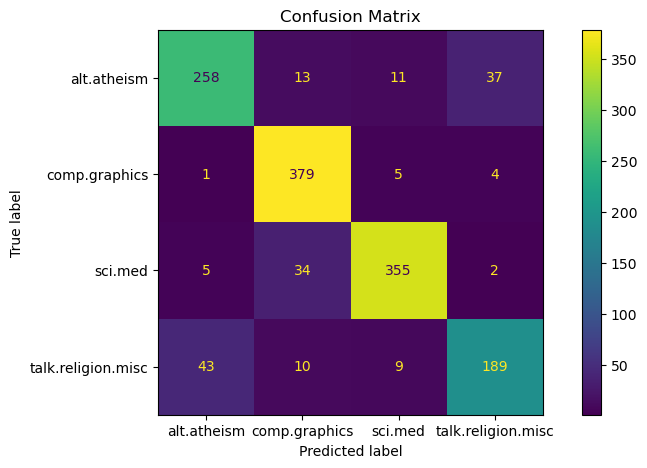

In [31]:
# Display confusion matrix
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(twenty_test.target, predicted, ax=ax)
ax.xaxis.set_ticklabels(twenty_train.target_names)
ax.yaxis.set_ticklabels(twenty_train.target_names)
_ = ax.set_title(
    f"Confusion Matrix"
)

## Parameter tuning using grid search

In [33]:
# Import dridsearch module
from sklearn.model_selection import GridSearchCV

# Choose set of parameters to fine-tune
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1, 0.1, 1e-2, 1e-3),
}

In [34]:
#  Define fine-tuning cross-validation
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)

In [35]:
# Fit models
gs_clf = gs_clf.fit(twenty_train.data, twenty_train.target)

In [36]:
# Classify new data
twenty_train.target_names[gs_clf.predict(['God is love'])[0]]

'talk.religion.misc'

In [ ]:
# Show accuracy of best model and parameters
print(gs_clf.best_score_)

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))



0.9626535626535627
clf__alpha: 0.01
tfidf__use_idf: True
vect__ngram_range: (1, 1)
